Analyzing Weather Data from OpenWeatherMap API

In [1]:
import requests
import pandas as pd
import datetime
# Set your OpenWeatherMap API key
api_key = 'fb365aa6104829b44455572365ff3b4e'

In [3]:
lat = 18.184135
lon = 74.610764
#https://openweathermap.org/api/one-call-3#how How to use api call
# Construct the API URL
api_url = f"http://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={api_key}"
# Send a GET request to the API
response = requests.get(api_url)
weather_data = response.json() #pass response to weather_data object(dictionary)
weather_data


{'cod': '200',
 'message': 0,
 'cnt': 40,
 'list': [{'dt': 1730743200,
   'main': {'temp': 297.5,
    'feels_like': 297.27,
    'temp_min': 297.5,
    'temp_max': 297.5,
    'pressure': 1013,
    'sea_level': 1013,
    'grnd_level': 950,
    'humidity': 49,
    'temp_kf': 0},
   'weather': [{'id': 803,
     'main': 'Clouds',
     'description': 'broken clouds',
     'icon': '04n'}],
   'clouds': {'all': 69},
   'wind': {'speed': 3.3, 'deg': 103, 'gust': 6.56},
   'visibility': 10000,
   'pop': 0,
   'sys': {'pod': 'n'},
   'dt_txt': '2024-11-04 18:00:00'},
  {'dt': 1730754000,
   'main': {'temp': 296.95,
    'feels_like': 296.69,
    'temp_min': 295.84,
    'temp_max': 296.95,
    'pressure': 1013,
    'sea_level': 1013,
    'grnd_level': 949,
    'humidity': 50,
    'temp_kf': 1.11},
   'weather': [{'id': 803,
     'main': 'Clouds',
     'description': 'broken clouds',
     'icon': '04n'}],
   'clouds': {'all': 51},
   'wind': {'speed': 2.92, 'deg': 148, 'gust': 2.87},
   'visibility'

In [4]:
len(weather_data['list'])

40

In [5]:
temperatures = [item['main']['temp'] for item in weather_data['list']]
timestamps = [pd.to_datetime(item['dt'], unit='s') for item in weather_data['list']]
temperature = [item['main']['temp'] for item in weather_data['list']]
humidity = [item['main']['humidity'] for item in weather_data['list']]
wind_speed = [item['wind']['speed'] for item in weather_data['list']]
weather_description = [item['weather'][0]['description'] for item in weather_data['list']]
# Create a pandas DataFrame with the extracted weather data
weather_df = pd.DataFrame({
'Timestamp': timestamps,
'Temperature': temperatures,
'humidity': humidity,
'wind_speed': wind_speed,
'weather_description': weather_description,
})
# Set the Timestamp column as the DataFrame's index
weather_df.set_index('Timestamp', inplace=True)
max_temp = weather_df['Temperature'].max()
max_temp

304.44

In [6]:
min_temp = weather_df['Temperature'].min()
min_temp

293.26

In [7]:
# Handling missing values
weather_df.fillna(0, inplace=True) # Replace missing values with 0 or appropriate value
# Handling inconsistent format (if applicable)
weather_df['Temperature'] = weather_df['Temperature'].apply(lambda x: x - 273.15 if isinstance(x, float)else x) 

In [8]:
print(weather_df)

                     Temperature  humidity  wind_speed weather_description
Timestamp                                                                 
2024-11-04 18:00:00        24.35        49        3.30       broken clouds
2024-11-04 21:00:00        23.80        50        2.92       broken clouds
2024-11-05 00:00:00        22.22        55        2.02    scattered clouds
2024-11-05 03:00:00        24.52        50        2.54           clear sky
2024-11-05 06:00:00        29.37        37        3.97           clear sky
2024-11-05 09:00:00        31.08        29        3.41           clear sky
2024-11-05 12:00:00        29.55        35        2.20           clear sky
2024-11-05 15:00:00        26.44        40        2.83          few clouds
2024-11-05 18:00:00        23.62        51        3.30          few clouds
2024-11-05 21:00:00        22.00        56        1.85           clear sky
2024-11-06 00:00:00        20.95        60        1.81           clear sky
2024-11-06 03:00:00      

In [10]:
import matplotlib.pyplot as plt

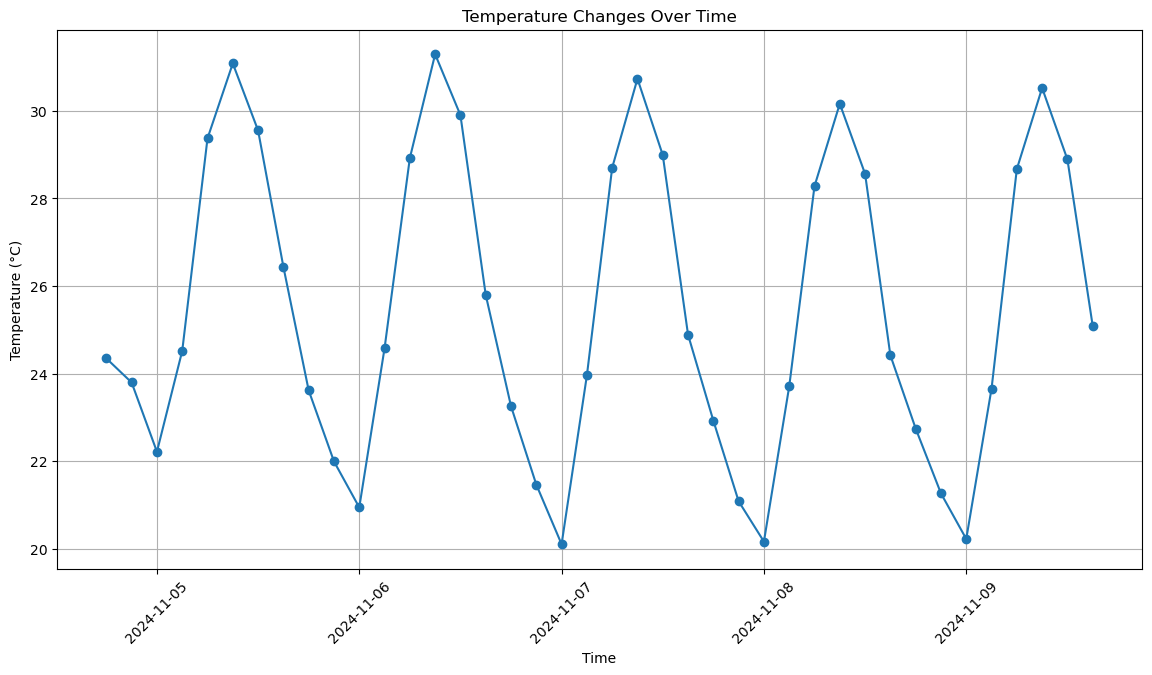

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(weather_df.index, weather_df['Temperature'], marker='o')
plt.title('Temperature Changes Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.grid()
plt.show()


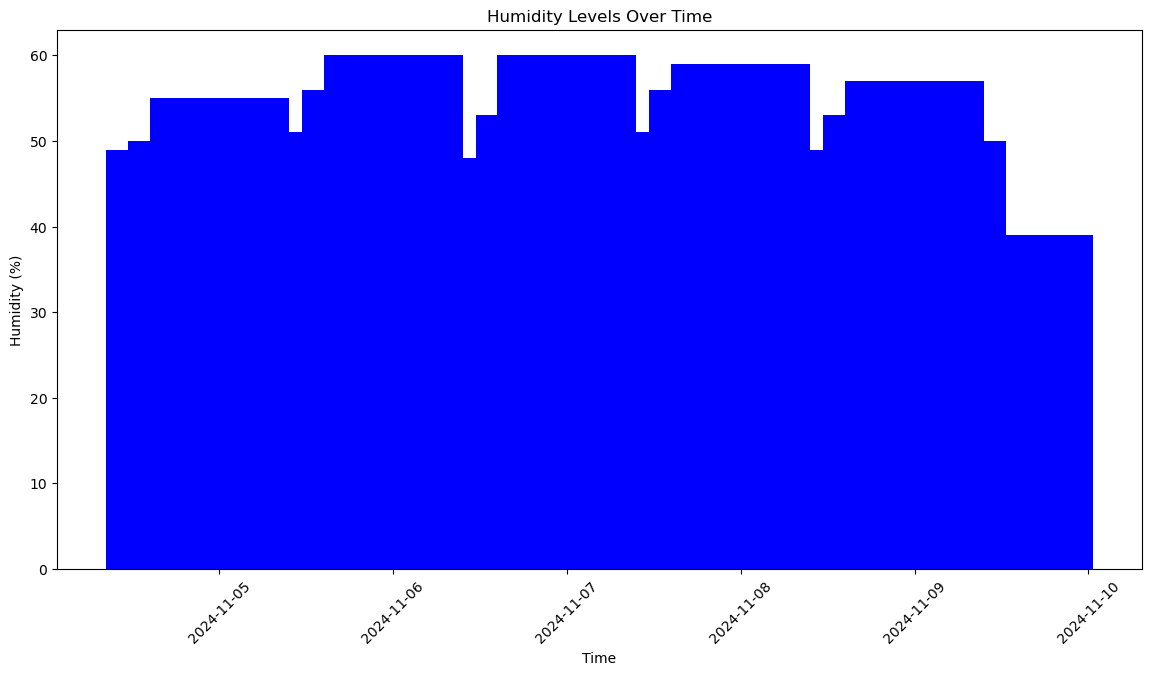

In [17]:
plt.figure(figsize=(14, 7))
plt.bar(weather_df.index, weather_df['humidity'], color='blue')
plt.title('Humidity Levels Over Time')
plt.xlabel('Time')
plt.ylabel('Humidity (%)')
plt.xticks(rotation=45)
plt.show()


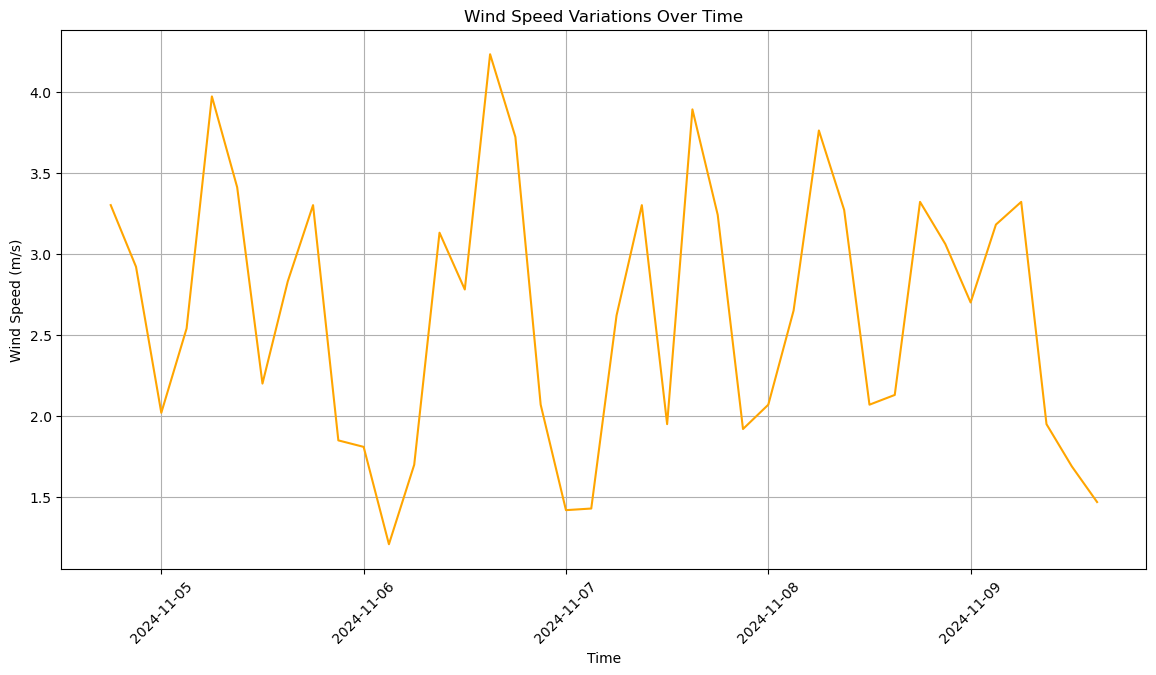

In [23]:
plt.figure(figsize=(14, 7))
plt.plot(weather_df.index, weather_df['wind_speed'], color='orange')
plt.title('Wind Speed Variations Over Time')
plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.xticks(rotation=45)
plt.grid()
plt.show()


data on daily and monthly levels

In [30]:

response = requests.get(api_url)
weather_data = response.json()

# Convert the JSON data into a DataFrame
df = pd.DataFrame(weather_data['list'])

# Convert the 'dt' column to datetime
df['dt'] = pd.to_datetime(df['dt'], unit='s')

# Extract relevant columns
df = df[['dt', 'main', 'weather', 'wind']]

# Normalize the main column
df_main = pd.json_normalize(df['main'])

# Normalize the weather column
df['weather'] = df['weather'].apply(lambda x: x[0])  # Take the first weather condition
df_weather = pd.json_normalize(df['weather'])

# Normalize the wind column
df_wind = pd.json_normalize(df['wind'])

# Combine the normalized data with the original DataFrame
df = df.join(df_main).join(df_weather[['description']]).join(df_wind)
df.drop(columns=['main', 'weather', 'wind'], inplace=True)

# Set the datetime as the index
df.set_index('dt', inplace=True)

# Daily aggregation
daily_summary = df.resample('D').agg({
    'temp': 'mean',
    'feels_like': 'mean',
    'temp_min': 'min',
    'temp_max': 'max',
    'humidity': 'mean',
    'speed': 'mean',  # Ensure 'speed' is now present
    'description': lambda x: x.mode()[0]  # Most common weather description
})

# Monthly aggregation
monthly_summary = df.resample('M').agg({
    'temp': 'mean',
    'feels_like': 'mean',
    'temp_min': 'min',
    'temp_max': 'max',
    'humidity': 'mean',
    'speed': 'mean',  # Ensure 'speed' is now present
    'description': lambda x: x.mode()[0]  # Most common weather description
})

# Output results
print("Daily Summary:")
print(daily_summary)

print("\nMonthly Summary:")
print(monthly_summary)


Daily Summary:
                 temp  feels_like  temp_min  temp_max   humidity     speed  \
dt                                                                           
2024-11-04  296.46000   296.19000    295.46    296.66  51.500000  3.080000   
2024-11-05  298.99750   298.41750    294.17    304.16  43.750000  2.856250   
2024-11-06  298.73750   298.11875    293.90    304.24  42.500000  2.618750   
2024-11-07  298.06625   297.41250    292.78    303.71  43.625000  2.343750   
2024-11-08  298.02500   297.40375    292.97    303.35  43.000000  2.740000   
2024-11-09  299.19500   298.47500    293.07    303.50  39.833333  2.076667   

              description  
dt                         
2024-11-04  broken clouds  
2024-11-05      clear sky  
2024-11-06      clear sky  
2024-11-07      clear sky  
2024-11-08      clear sky  
2024-11-09      clear sky  

Monthly Summary:
                temp  feels_like  temp_min  temp_max  humidity    speed  \
dt                                         